In [35]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan, stop_gradient, cond
import jax.random as jnp_random
import jax.numpy as np

from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import elementwise, Tanh, Selu, Relu
from jax.flatten_util import ravel_pytree

import numpy as onp

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power) 

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [94]:

n,m,T = 2, 1, 4

def softmax(a, b, eps):
    return 0.5 * ( a + b + np.sqrt((a-b)**2 + eps**2) )

def ell(x, u):
    return 0*(x[0]-2.)**2

def phi(x):
    return x[0]

def guard(x):
    return phi(x)<=0.

@jit
def f(x, u):
    _xdot = np.array([x[1], -9.81 + 200*softmax(-guard(x), 0., 1e-8) - 0.5*x[1]]) #+ np.clip(u[0], 0, -10) 
    return _xdot


def adjoint(x, u, rho):
    return grad(ell)(x, u) + jacfwd(f)(x, u).T @ rho

# def u_prime(x, rho):
#     return -1/0.002 * jacfwd(f,argnums=1)(x,np.ones(m)).T @ rho

def Hamiltonian(x, u, rho):
    return rho @ f(x, u) + ell(x, u)




In [95]:
x0 = np.array([1.0, 0.])
dt = 0.01
log = []
for t in range(400):
    log.append(x0.copy())
    x0 = x0 + dt * f(x0, np.zeros((1,))) 

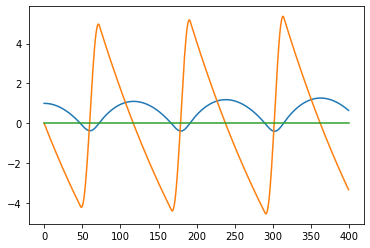

In [96]:
t = np.arange(0,len(log))
plt.plot(t, log)

plt.plot(t, np.zeros_like(t))

In [75]:
from jax.nn.initializers import glorot_normal, normal, uniform

def sin(x):
    return np.cos(x)
def exp(x):
    return np.exp(x)
Sin = elementwise(sin)
Exp = elementwise(exp)
x_init, x_net = stax.serial(
    stax.Dense(164), Sin,
    stax.Dense(164), Sin,
    stax.Dense(n)
)
# x_init, x_net = stax.serial(
#     stax.Dense(256, W_init=normal(stddev=10.0)),Sin,
#     stax.Dense(n)
# )
rho_init, rho_net = stax.serial(
    stax.Dense(164),Sin,
    stax.Dense(164),Sin,
    stax.Dense(n)
)
u_init, u_net = stax.serial(
    stax.Dense(164),Sin,
    stax.Dense(164),Sin,
    stax.Dense(m)
)

# x_init, x_net = stax.serial(
#     stax.Dense(64),Relu,
#     stax.Dense(64),Relu,
#     stax.Dense(n)
# )

# rho_init, rho_net = stax.serial(
#     stax.Dense(64),Relu,
#     stax.Dense(64),Relu,
#     stax.Dense(n)
# )
# u_init, u_net = stax.serial(
#     stax.Dense(64),Relu,
#     stax.Dense(64),Relu,
#     stax.Dense(m)
# )

rho_dot = jacfwd(rho_net, argnums=1)
x_dot = jacfwd(x_net, argnums=1)
# x0 = np.ones((n,))
x0 = np.array([1., 0.])

rng = jnp_random.PRNGKey(0)
in_shape = (-1, n)
_, x_params = x_init(rng, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, rho_params = rho_init(_rng_val, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, u_params = u_init(rng, (-1, 1))

In [32]:
opt_init, opt_update, get_params = optimizers.adam(step_size=3e-4)
opt_state = opt_init([x_params, rho_params, u_params])

In [33]:
def loss(params, t):
    x_params, rho_params, u_params = params
    dxdt    = vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze()
    drhodt  = vmap(rho_dot, in_axes=(None, 0))(rho_params, t).squeeze()
    x       = vmap(x_net, in_axes=(None, 0))(x_params, t).squeeze()
    rho     = vmap(rho_net, in_axes=(None, 0))(rho_params, t).squeeze()
    u       = vmap(u_net, in_axes=(None, 0))(u_params, t)[:,:,0]#.squeeze()
    return np.mean((dxdt - vmap(f)(x, u))**2 \
            + (drhodt + vmap(adjoint)(x, u, rho))**2 \
            + (x[0]-x0)**2 + (rho[-1] - grad(ell)(x[-1], u[-1]))**2) \
            + np.mean(vmap(Hamiltonian)(stop_gradient(x), u, stop_gradient(rho)))

@jit 
def step(i, opt_state, t):
    params = get_params(opt_state)
    g = grad(loss)(params, t)
    return opt_update(i, g, opt_state)


21.346844


KeyboardInterrupt: 

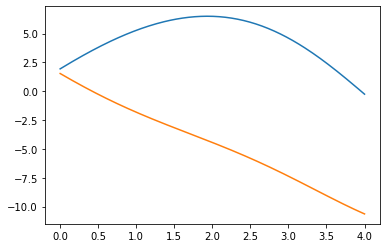

In [34]:
t = np.linspace(0, T, num=200)
# t = powspace(0, T, power=2, num=200)
for i in range(5000):
    _t = np.array(
        onp.concatenate([
            [0.0],onp.random.uniform(0,T, size=(200,)), [T] ]
            ))
    opt_state = step(i, opt_state, _t)
    if i % 100 == 0:
        clear_output(wait=True)
        x_params, rho_params, u_params = get_params(opt_state)
        print(loss(get_params(opt_state), t))
        _x = vmap(x_net, in_axes=(None,0))(x_params, t).squeeze()
        _rho = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
        _u = vmap(u_net, in_axes=(None,0))(u_params, t).squeeze()
        plt.plot(t, _x)
        # plt.plot(t, _u)
        plt.pause(0.01)

In [54]:
print(loss(get_params(opt_state), t))
x_params, rho_params, u_params = get_params(opt_state)

[48.118046 48.118046]


In [138]:
x = vmap(x_net, in_axes=(None,0))(x_params, t).squeeze()
rho = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
u = vmap(u_net, in_axes=(None,0))(u_params, t)


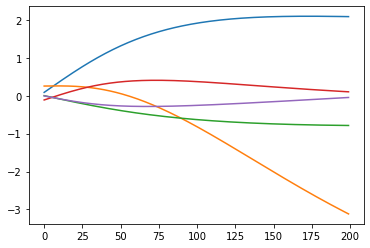

In [139]:
plt.plot(x)
plt.plot(u.squeeze())
plt.plot(rho)
# plt.plot(vmap(f)(x,u)-vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze())
# plt.plot(vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze())
# plt.plot(u)